Exploring the double well
------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
import sys

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import EnergyInvNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
def test_sample(network, temperature=1.0):
    sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=100000)
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(5, 4))
    _, E = double_well.plot_dimer_energy(temperature=temperature)
    h, b = np.histogram(sample_x[:, 0], bins=100)
    Eh = -np.log(h) / temperature
    Eh = Eh - Eh.min() + E.min()
    bin_means = 0.5*(b[:-1] + b[1:])
    plt.plot(bin_means, Eh)
    return bin_means, Eh

In [7]:
# reweighting
def test_sample_rew(network, temperature=1.0):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(5, 4))
    double_well.plot_dimer_energy()
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [8]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [9]:
def getx(x):
    return x[:, 0]

In [10]:
def plot_convergence(losses, acceptance_rate, stepsize=None, figsize=(5, 8)):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=figsize)
    niter = len(losses)
    xticks = np.arange(niter) + 1
    # ML loss
    losses_ML = np.array(losses)[:, 1]
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    # KL loss
    losses_KL = np.array(losses)[:, 2]
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    if stepsize is None:
        # acceptance rate
        axes[2].plot(xticks, acceptance_rate, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Acc. rate')
        axes[2].set_xlabel('Training iterations')
    else:
        # MCMC efficiency (adaptive)
        efficiency = np.array(acceptance_rate) * np.array(stepsize)
        axes[2].plot(xticks, efficiency, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Efficiency')
        axes[2].set_xlabel('Training iterations')
    return fig, axes

In [11]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Double well
---

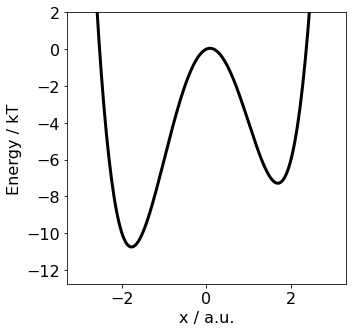

In [11]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

In [12]:
def plot_potential(labels=True, cbar=True, figsize=(5, 5)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-6, 6, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        cbar = plt.colorbar()
        cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$ / a.u.')
        plt.ylabel('$x_2$ / a.u.')
    else:
        plt.xticks([])
        plt.yticks([])        

In [13]:
print(params)

{'a4': 1.0, 'a2': 6.0, 'a1': 1.0, 'k': 1.0, 'dim': 2}


In [14]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [15]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5, 0, 'Probability')

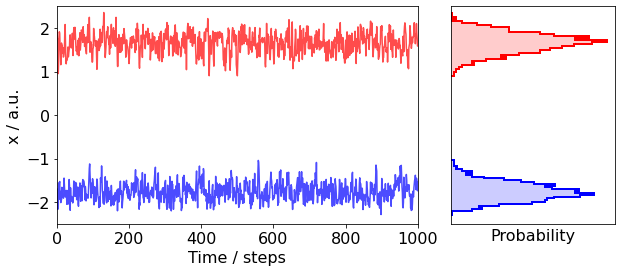

In [16]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('x / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')
#plt.savefig(paper_dir + 'figs/doublewell_prior_trajs.pdf', bbox_inches='tight')

In [17]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [18]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

Particle filter starting from one sample
-----

In [19]:
bg = invnet(double_well.dim, 'RRRR', double_well, nl_layers=3, nl_hidden=100, 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
x0 = traj_left[100:101]
X0 = np.repeat(x0, 1000, axis=0)
X0 += 0.01 * np.random.randn(X0.shape[0], X0.shape[1])

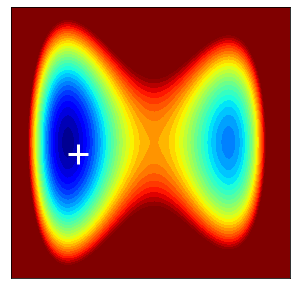

In [21]:
plot_potential(labels=False, cbar=False, figsize=(5, 5))
plt.plot(x0[:, 0], x0[:, 1], color='white', linewidth=0, marker='+', markersize=20, markeredgewidth=3)
#plt.savefig(paper_dir + 'figs/double_well/explore_potential_init.pdf', bbox_inches='tight', transparent=True)

In [22]:
loss_bg_trainML, loss_bg_valML = bg.train_ML(X0, epochs=20, batch_size=128, 
                                             std=1.0, verbose=0, return_test_energies=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



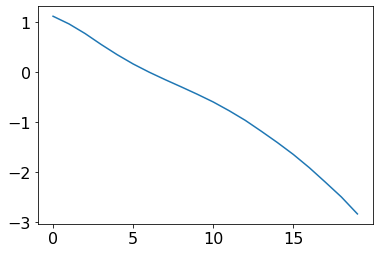

In [23]:
plt.plot(loss_bg_trainML)
plt.plot(loss_bg_valML)

In [25]:
from deep_boltzmann.networks.training import ParticleFilter

In [28]:
particle_filter = ParticleFilter(bg, X0, 10000, lr=0.00025, batch_size=1024, 
                                 high_energy=10000, max_energy=1e10, std=1.0)

In [29]:
Ds = []
Ds.append(particle_filter.X[:, 0].copy())

In [30]:
for i in range(10):
    print('\nITER',(i+1),'/10')
    particle_filter.train(epochs=50, stepsize=None, verbose=1)
    Ds.append(particle_filter.X[:, 0].copy())


ITER 1 /10
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 0/50 loss 2.3956 index_layer_3_loss -2.6828 index_layer_6_loss 5.0784 p_acc 0.896484375 step 0.1
Epoch 1/50 loss 8.5126 index_layer_3_loss -2.5342 index_layer_6_loss 11.0468 p_acc 0.9013671875 step 0.1
Epoch 2/50 loss 1.2440 index_layer_3_loss -2.6794 index_layer_6_loss 3.9234 p_acc 0.8955078125 step 0.1
Epoch 3/50 loss -0.9248 index_layer_3_loss -2.7503 index_layer_6_loss 1.8254 p_acc 0.896484375 step 0.1
Epoch 4/50 loss -2.2952 index_layer_3_loss -2.7034 index_layer_6_loss 0.4081 p_acc 0.888671875 step 0.1
Epoch 5/50 loss -2.3167 index_layer_3_loss -2.6804 index_layer_6_loss 0.3637 p_acc 0.88671875 step 0.1
Epoch 6/50 loss -2.6029 index_layer_3_loss -2.7195 index_layer_6_loss 0.1166 p_acc 0.90234375 step 0.1
Epoch 7/50 loss -3.4350 index_layer_3_loss -2.7567 index_layer_6_loss -0.6783 p_acc 0.8974609375 step 0.1
Epoch 8/50 loss -3.5535 index_layer_3_loss -2.7357 index_layer_6_loss -0.8179 

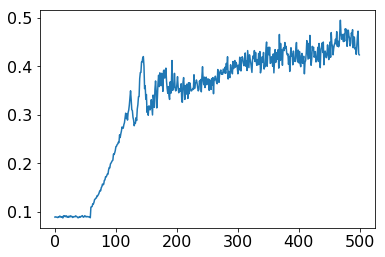

In [40]:
plt.plot(np.array(particle_filter.acceptance_rate) * np.array(particle_filter.stepsize))

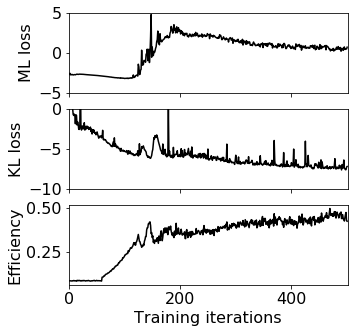

In [46]:
fig, axes = plot_convergence(particle_filter.loss_train, particle_filter.acceptance_rate, particle_filter.stepsize, figsize=(5, 5));
axes[0].set_ylim(-5, 5)
axes[1].set_ylim(-10, 0)
#plt.savefig(paper_dir + 'figs/double_well/explore_conv.pdf', bbox_inches='tight')

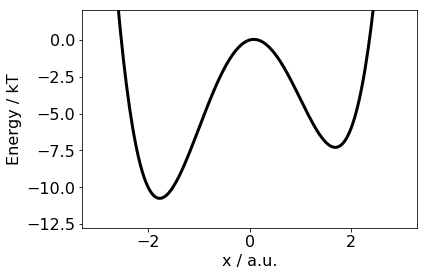

In [48]:
xref, Eref = double_well.plot_dimer_energy()

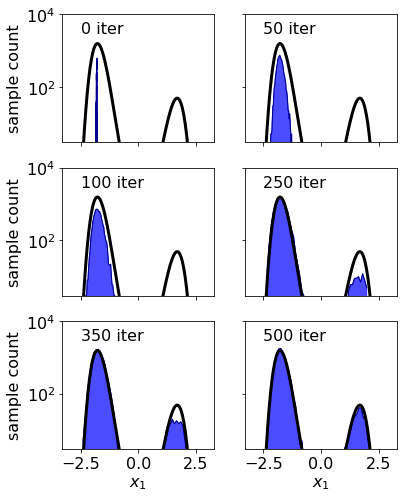

In [50]:
plot_indices = np.array([0, 1, 2, 5, 7, 10])
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6,8))

for i, ax in zip(plot_indices, axes.flatten()):
    h, e = np.histogram(Ds[i], bins=50)
    e = 0.5*(e[:-1] + e[1:])
    ax.plot(e, h, color='darkblue', linewidth=1)
    ax.fill_between(e, np.zeros(len(e)), h, color='blue', alpha=0.7)
    ax.text(-2.5, 3000, str(i*50)+' iter')
    ax.plot(xref, np.exp(-Eref-3.4), color='black', linewidth=3, label='Eq. dist.')
    ax.semilogy()
    #plt.legend(ncol=1, fontsize=16, frameon=False)
    ax.set_ylim(3, 10000)
axes[-1, 0].set_xlabel('$x_1$')
axes[-1, 1].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('sample count')
axes[1, 0].set_ylabel('sample count')
axes[2, 0].set_ylabel('sample count')
#plt.savefig(paper_dir + 'figs/double_well/explore_conv_hist.pdf', bbox_inches='tight')